## GMSNetのモデルを作成する  train,eval,test のデータに分ける

2024/5/17 時点での完成版

コードをすべて問題なく実行できるようにはなった。
最適化されたメッシュを取り出してくることもでき、しっかり更新できている。
しかし、損失の値が全く減少せず、むしろ増加していてほぼもともとのメッシュのままの出力が最適化メッシュとして出てきてしまう。
ゆえに、最適化できているとは到底言えない。


# シフト切り捨てをやめてみる
# トレーニング完了後のトレーニングメッシュを表示してみる

In [1]:
import copy
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from torch_geometric.nn import GCNConv
from torch_geometric.nn.norm import GraphNorm
import torch_geometric.transforms as T
from torch.nn import Linear, InstanceNorm2d, InstanceNorm1d
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
import matplotlib.pyplot as plt
from torch_geometric.transforms import FaceToEdge
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from itertools import combinations
import vtk
import glob
from torch_scatter import scatter_mean
from tqdm import tqdm
# 計算を軽くするためのライブラリ
from torch.cuda import empty_cache
import gc               # メモリリークを防ぐ

In [2]:
num_train_epoch = 100
num_test_epoch = 5
num_trial = 2

# Dataの準備

In [3]:
class Dataset(Dataset):
    def __init__(self, num_files):
        None

class Mesh(Dataset):
    def __init__(self):
        self.coordinates = None
        self.faces = None

class Polygon(Dataset):
    def __init__(self, num_node, num_face):
        self.parent_meshID = None
        self.coordinates = torch.zeros(num_node, 2)
        self.faces = torch.zeros(num_face, 3)
        self.edges = None
        self.d = None
        self.Cx = None
        self.Cy = None
        self.x_min = None
        self.y_min = None

class PolygonID(Dataset):
    def __init__(self, nodeID):
        self.nodeID = nodeID
        # self.parent_meshID = None

class Polygon_data(Dataset):
    def __init__(self, polygonID, meshID, nodeID):
        self.polygonID = polygonID
        self.meshID = meshID
        self.nodeID = nodeID

class Minibatch(Dataset):
    def __init__(self):
        self.x = None
        self.edge_index = None
        self.batch = None

In [4]:
def create_mesh_polygonID_data(vtk_file_path, polygonID_list, poly_count, polygon_dict, mesh_index):
    reader = vtk.vtkDataSetReader()
    reader.SetFileName(vtk_file_path)
    reader.Update()

    data = reader.GetOutput()
    
    mesh = Mesh()
    # 座標情報を取得
    points = data.GetPoints()
    num_points = points.GetNumberOfPoints()
    coordinates = torch.zeros(num_points, 3)
    for i in range(num_points):
        coordinates[i] = torch.tensor(points.GetPoint(i))

    mesh.coordinates = coordinates[:, :2]                        # mesh.coordinates を定義

    # 面情報を取得
    polys = data.GetPolys()
    num_polys = polys.GetNumberOfCells()
    mesh.faces = torch.zeros(num_polys, 3, dtype=int)           # mesh.faces を定義

    # 各三角形の情報を取得
    polys.InitTraversal()
    for i in range(num_polys):
        cell = vtk.vtkIdList()
        if polys.GetNextCell(cell) == 0:
            break
        mesh.faces[i] = torch.tensor([cell.GetId(0), cell.GetId(1), cell.GetId(2)])
        
# ------------ mesh のデータを取得完了 -------------------------


    # 各セルの各辺の隣接セル数を調べる
    edge_neighbors = {}
    num_cells = data.GetNumberOfCells()
    for cell_index in range(num_cells):
        cell = data.GetCell(cell_index)
        num_edges = cell.GetNumberOfEdges()

        for edge_index in range(num_edges):
            edge = cell.GetEdge(edge_index)
            edge_points = edge.GetPointIds()

            # 辺を構成する点のインデックスを取得
            point1_id = edge_points.GetId(0)
            point2_id = edge_points.GetId(1)

            # 辺を構成する点のインデックスを照準にソート
            edge_key = (min(point1_id, point2_id), max(point1_id, point2_id))

            # 辺の隣接セル数をカウント
            if edge_key in edge_neighbors:
                edge_neighbors[edge_key] += 1
            else:
                edge_neighbors[edge_key] = 1 

    boundary_edges = []
    # 境界上の辺を特定
    for edge_key, num_neighbors in edge_neighbors.items():
        if num_neighbors == 1:
            boundary_edges.append(edge_key)

    # 境界上の辺を構成する頂点の番号を取得
    boundary_points = set()     # 集合を表すデータ型、順番を持たず、重複した要素は取り除かれる
# ---------------- 自由点かどうかの判定完了 ------------------------
    

    for edge_key in boundary_edges:
        boundary_points.add(edge_key[0])
        boundary_points.add(edge_key[1])
    
    
    for pointId in range(num_points):       # pointId:自由点の頂点番号
        if pointId in boundary_points:
            continue
        else:
            poly_count += 1
            # print("pointId:", pointId)
        mask = (mesh.faces == pointId)
        if mask.any():
            count = torch.sum(mask).item()
        num_node = count + 1
        num_face = count
        polygon_number = poly_count - 1 



        
        polygon_i = f"polygon_{polygon_number}"
        # print(polygon_i)
        polygon_i = Polygon(num_node, num_face)
        
        element_to_check = pointId
        polygon_i.face = mesh.faces[(mesh.faces == element_to_check).any(dim=1)]
        # print(polygon_i.face)

        polygon_i.nodeId = set()
        for i in range(len(polygon_i.face)):
            polygon_i.nodeId.add(polygon_i.face[i, 0].item())
            polygon_i.nodeId.add(polygon_i.face[i, 1].item())
            polygon_i.nodeId.add(polygon_i.face[i, 2].item())
        sorted_nodeId = sorted(polygon_i.nodeId)
        polygon_i.nodeID = torch.tensor(list(sorted_nodeId))
        
        point_id_index = (polygon_i.nodeID == pointId).nonzero().item()

        value_to_move = polygon_i.nodeID[point_id_index]
        polygon_i.nodeID = torch.cat((value_to_move.unsqueeze(0), polygon_i.nodeID[polygon_i.nodeID != pointId]))
        # print(polygon_i.nodeID)
        setattr(polygon_i, "parent_meshID", mesh)
        polygonID_list.append(f"polygon_{polygon_number}")

        keyword = f"polygon_{polygon_number}"
        valiables = (f"mesh_{mesh_index}", polygon_i.nodeID)
        polygon_dict[keyword] = valiables

    # --------- polygon.nodeID の取得完了 -------------
    return mesh, polygonID_list, poly_count, polygon_dict

# Dataset の作成

In [5]:
def create_mesh_polygon_dataset(vtk_files):
    num_vtk_files = len(vtk_files)
    polygonID_list = []
    mesh_data_list = []
    poly_count = 0
    polygon_dict = {}
    # ファイルに順にアクセスする
    for i in range(num_vtk_files):
        # print("File Name:", vtk_files[i])
        mesh, polygonID_list, poly_count, polygon_dict = create_mesh_polygonID_data(vtk_files[i], polygonID_list, poly_count, polygon_dict, i)
        mesh_data_list.append(mesh)
    return mesh_data_list, polygonID_list, polygon_dict


In [6]:
# 以下、i はpolygon番号で座標と面情報を取得することができる
face_to_edge = T.FaceToEdge(remove_faces=False)
def data_getter(polygonID, num_mesh_data_list, mesh_data_list, polygon_data_list):
    
    polygon_meshID = int(polygon_data_list[polygonID].meshID.split("_")[-1])
    mesh = mesh_data_list[polygon_meshID]
    
    num_node = len(polygon_data_list[polygonID].nodeID)
    num_face = num_node - 1 
    polygon_i = Polygon(num_node, num_face)

    # print(polygon_data_list[polygonID].nodeID)      # polygon に属する頂点の番号

    polygon_i.coordinates = mesh.coordinates[polygon_data_list[polygonID].nodeID]     # polygonの座標
    # print(polygon_i.coordinates)

    # print(polygon_i.faces)

    # polygon_i.faces を取得するコード
    
    element_to_check = polygon_data_list[polygonID].nodeID[0]
    polygon_i.face = mesh.faces[(mesh.faces == element_to_check).any(dim=1)]

    indices = torch.nonzero(torch.isin(polygon_i.face, polygon_data_list[polygonID].nodeID))
    for idx in range(indices.size(0)):
        row_idx, col_idx = indices[idx]
        value_to_replace = polygon_i.face[row_idx, col_idx]
        polygon_i.face[row_idx, col_idx] = (polygon_data_list[polygonID].nodeID == value_to_replace).nonzero().item()
    polygon_i.faces = polygon_i.face.long()

    # 各行の三角形からエッジを抽出してedge_indexを構築
    edges = torch.cat([ polygon_i.faces[:, [0, 1]],
                        polygon_i.faces[:, [1, 2]],
                        polygon_i.faces[:, [2, 0]]], dim=0)

    # エッジのインデックスをソートして重複を削除
    edge_index = torch.tensor(sorted(edges.numpy().tolist())).unique(dim=0)
    polygon_i.edge_index = torch.transpose(edge_index, 0, 1)
    return polygon_i



# メッシュをプロットする関数

In [33]:
def plot_mesh(mesh, title):

    vertices = mesh.coordinates
    faces = mesh.faces
    fig = plt.figure(figsize=(6, 12))
    ax = fig.add_subplot(111, aspect="equal")

    # 描画するメッシュの頂点をプロット
    # ax.plot(vertices[:,0], vertices[:,1], 'bo')  # 頂点を青色の点でプロット
    # ax.plot(vertices[:,0], vertices[:,1], 'k-')  # 辺を黒色の線でプロット

    # 各三角形をプロット
    for face in faces:
        v0, v1, v2 = vertices[face]
        v0_np = v0.detach().numpy()
        v1_np = v1.detach().numpy()
        v2_np = v2.detach().numpy()
        ax.plot([v0_np[0], v1_np[0], v2_np[0], v0_np[0]], [v0_np[1], v1_np[1], v2_np[1], v0_np[1]], 'b-')  # 三角形を赤色の線でプロット

    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.axhline(0, color="black", linewidth=0.001)
    ax.axvline(0, color="black", linewidth=0.001)

    plt.xlim(-300, 150)
    plt.ylim(-200, 1400)
    # plt.savefig(f"/mnt/{title}.png", format="png")
    plt.show()
    plt.close()


# meshデータからvtkファイルを出力する関数

In [8]:
def vtk_output(mesh, title):
    vertices = mesh.coordinates
    faces = mesh.faces
    num_vertices = len(vertices)
    num_faces = len(faces)


    # vertices を３次元に戻す
    z_column = torch.zeros(vertices.shape[0], 1)
    vertices = torch.cat((vertices, z_column), dim=1)

    with open(f"/mnt/optimized_data/{title}.vtk", "w") as f:
        f.write("# vtk DataFile Version 2.0\n")
        f.write("FOR TEST\n")
        f.write("ASCII\n")
        f.write("DATASET POLYDATA\n")

        f.write("POINTS {} float\n".format(num_vertices))
        for vertex in vertices:
            f.write("{:.15f} {:.15f} {:.15f}\n".format(*vertex))

        f.write("\nPOLYGONS {} {}\n".format(num_faces, num_faces * 4))
        for face in faces:
            f.write("3 ")
            f.write(" ".join(str(idx.item()) for idx in face))
            f.write("\n")
       



# Normalization

In [9]:
def normalization(polygon):
    vertices = polygon.coordinates
    normalized_vertices = vertices.clone()
    centered_vertices = vertices.clone()
    # print(vertices)

    max_x = torch.max(vertices[:,0])
    min_x = torch.min(vertices[:,0])
    max_y = torch.max(vertices[:,1])
    min_y = torch.min(vertices[:,1])

    polygon.d = torch.max(max_x - min_x, max_y - min_y)
    polygon.x_min = min_x
    polygon.y_min = min_y

    normalized_vertices = (vertices - torch.tensor([polygon.x_min, polygon.y_min])) / polygon.d

    
    polygon.Cx = normalized_vertices[0,0].item()
    polygon.Cy = normalized_vertices[0,1].item()   

    centered_vertices = normalized_vertices - torch.tensor([polygon.Cx, polygon.Cy])
    polygon.coordinates = centered_vertices
    
    # print("Normalized polygon:", vertices)

    return polygon


    


# denormalization

In [10]:
def denormalization(polygon):
    vertices = polygon.coordinates
    shifted_vertices = vertices.clone()
    denormalized_vertices = vertices.clone()
    
    shifted_vertices = vertices + torch.tensor([polygon.Cx, polygon.Cy])
        

    denormalized_vertices = polygon.d * shifted_vertices + torch.tensor([polygon.x_min, polygon.y_min])
    polygon.coordinates = denormalized_vertices
    return polygon


# MetricLoss

In [11]:
class MetricLoss:
    def select_vertices(self, vertices, face):
        v0 = vertices[face[0]]
        v1 = vertices[face[1]]
        v2 = vertices[face[2]]
        return v0, v1, v2 

    def edge_length(self, v0, v1, v2):
        l1 = torch.sqrt((v0[0] - v1[0])**2 + (v0[1] - v1[1])**2)
        l2 = torch.sqrt((v1[0] - v2[0])**2 + (v1[1] - v2[1])**2)
        l3 = torch.sqrt((v2[0] - v0[0])**2 + (v2[1] - v0[1])**2)

        return l1, l2, l3

    def face_area(self, l1, l2, l3):
        s = (l1 + l2 + l3)/2
        face_area = torch.sqrt(s*(s-l1)*(s-l2)*(s-l3))
        return face_area

    def compute_loss(self, vertices, face):
        v0, v1, v2 = self.select_vertices(vertices, face)
        l1, l2, l3 = self.edge_length(v0, v1, v2)
        s = self.face_area(l1, l2, l3)

        q = (l1**2 + l2**2 + l3**2)/(4.0*torch.sqrt(torch.tensor(3.))*s)
        q = q.clone().detach().requires_grad_(True)
        return 1-1/q

    def __call__(self, polygon):
        vertices = polygon.coordinates
        faces = polygon.faces
        loss = 0 
        for face in faces:
            loss = loss + self.compute_loss(vertices, face)
        
            metric_loss = ((loss/(len(polygon.coordinates[:,0])-1)).clone().detach().requires_grad_(True))
        return metric_loss
    



# meshデータからq_hatを求める関数

In [12]:
def calculate_q_hat(mesh):
    vertices = mesh.coordinates
    faces = mesh.faces
    r_list = []
    alpha_list = []
    beta_list = []

    for face in faces:
        # a(最小角)と b(最大角)を求める

        angles = []
        v0, v1, v2 = m_loss.select_vertices(vertices, face)
        l1, l2, l3 = m_loss.edge_length(v0, v1, v2)

        # 余弦定理から各角度の余弦値を計算
        cos_alpha = (l2**2 + l3**2 - l1**2) / (2*l2*l3)
        cos_beta = (l1**2 + l3**2 - l2**2) / (2*l1*l3)
        cos_gamma = (l1**2 + l2**2 - l3**2) / (2*l1*l2)
        # 余弦値から角度を計算して個度法に変換
        alpha = torch.acos(cos_alpha) * 180 / np.pi
        beta = torch.acos(cos_beta) * 180 / np.pi
        gamma = torch.acos(cos_gamma) * 180 / np.pi

        angles.append(alpha)
        angles.append(beta)
        angles.append(gamma)

        min_angle = min(angles)
        max_angle = max(angles)

        alpha_list.append(min_angle)
        beta_list.append(max_angle)



        # 1/q = r を求める

        r = 1 - m_loss.compute_loss(vertices, face) 
        r_list.append(r)

    a_mean = sum(alpha_list) / len(alpha_list)
    a_min = min(alpha_list)
    b_mean = sum(beta_list) / len(beta_list)
    b_max = max(beta_list)
    r_mean = sum(r_list) / len(r_list)
    r_min = min(r_list)

    q_hat = (((a_mean + a_min + 120 - b_max - b_mean)/60) + r_mean + r_min) / 6

    return q_hat

    


    
    

スターポリゴンの中から外側に自由点が移動したときに自由点の移動量を半分にしてもう一度外に行っていないか検証する
自由点が外に行かないことを確認したあとのスターポリゴンを返す

In [13]:
def check(polygon, polygonID):
    # print("polygonID:", polygonID)
    vertices = polygon.coordinates
    
    edge_index = polygon.edge_index
    
    return_value = True
    while return_value == True:   

        for i in range(1, len(vertices[:,0])):
            point1 = torch.tensor([0.0, 0.0])
            point2 = vertices[0]
            point3 = vertices[i]
            
            pos_i = torch.where(edge_index[0] == i)
            pos_i = pos_i[0]
            # print("edge_index[0]", edge_index[0])
            
            for j in range(len(pos_i)):
                if edge_index[1, pos_i[j]] == 0:
                    continue
                else:
                    val_pos_i = edge_index[1, pos_i[j]]
                    break

            point4 = vertices[val_pos_i]


            a1 = 0
            b1 = 0
            a2 = 0
            b2 = 0
            check1 = 0
            check2 = 0
            check3 = 0
            check4 = 0
            x1 = point1[0]
            y1 = point1[1]
            x2 = point2[0]
            y2 = point2[1]
            x3 = point3[0]
            y3 = point3[1]
            x4 = point4[0]
            y4 = point4[1]
            a1 = (y1 - y2)/(x1-x2)
            b1 = y1 - (a1*x1)
            a2 = (y3 - y4)/(x3-x4)
            b2 = y3 - (a2*x3)
            check1 = (a1*x3) - y3 + b1 
            check2 = (a1*x4) - y4 + b1    # point1,2を通る直線に対してpoint3,4を結ぶ線分が交差しているか
            check3 = (a2*x1) - y1 + b2
            check4 = (a2*x2) - y2 + b2    # point3,4を通る直線に対してpoint1,2を結ぶ線分が交差しているか
            # print("1:",check1,"2:",check2,"3:",check3,"4:",check4)
            del a1, a2, b1, b2, x1, x2, x3, x4, y1, y2, y3, y4 

            if (check1*check2) <= 0 and (check3*check4) <= 0 :
                return_value = True
                # print("Out_of_StarPolygon")
                vertices[0] = 0.5*vertices[0]
                polygon.coordinates[0] = vertices[0]
                break
            else:
                return_value = False
                continue       
            
        
    # plot_mesh(polygon, "polygon_checked")
               
    return polygon

# Model 隠れ層のノード数は何にするか未定

In [14]:
num_dimensions = 2

class GMSNet(torch.nn.Module):
    def __init__(self, hidden_channnels):
        super(GMSNet, self).__init__()
        torch.manual_seed(42)
        self.lin = Linear(num_dimensions, num_dimensions)
        self.GNorm = GraphNorm(num_dimensions, num_dimensions)
        self.conv = GCNConv(num_dimensions, num_dimensions)
        self.fc1 = Linear(num_dimensions, hidden_channnels)
        self.ISNorm = InstanceNorm1d(hidden_channnels, hidden_channnels)
        self.fc2 = Linear(hidden_channnels, num_dimensions)

    def forward(self, x, edge_index, batch):       
        x = self.lin(x)
        x = self.GNorm(x)
        x = x.relu()
        x = self.conv(x, edge_index) + x 
        x = self.fc1(x)
        x = self.ISNorm(x)
        x = self.fc2(x)

        x = scatter_mean(x, batch, dim=0)   # batch内のサンプルの出力の平均を取って１つのテンソルにする

        return x


# Main

In [15]:
# フォルダ内のすべてのvtkファイルにアクセスする
train_vtk_files = glob.glob("/mnt/Train_Data/*.vtk")
eval_vtk_files = glob.glob("mnt/Eval_Data/*.vtk")
test_vtk_files = glob.glob("mnt/Test_Data/*vtk")

num_train_mesh = len(train_vtk_files)
print("num_train_mesh:", num_train_mesh)
train_mesh_data_list, train_polygonID_list, train_polygon_dict = create_mesh_polygon_dataset(train_vtk_files)
eval_mesh_data_list, eval_polygonID_list, eval_polygon_dict = create_mesh_polygon_dataset(eval_vtk_files)
test_mesh_data_list, test_polygonID_list, test_polygon_dict = create_mesh_polygon_dataset(test_vtk_files)


    
# ポリゴンデータを格納するリストを作成
train_polygon_data_list = []
eval_polygon_data_list = []
test_polygon_data_list = []

for i in range(len(train_polygonID_list)):
    polygonID = f"polygon_{i}"
    meshID = train_polygon_dict[f"polygon_{i}"][0]
    nodeID = train_polygon_dict[f"polygon_{i}"][1]
    polygon_data = Polygon_data(polygonID, meshID, nodeID)
    train_polygon_data_list.append(polygon_data)

for i in range(len(eval_polygonID_list)):
    polygonID = f"polygon_{i}"
    meshID = eval_polygon_dict[f"polygon_{i}"][0]
    nodeID = eval_polygon_dict[f"polygon_{i}"][1]
    polygon_data = Polygon_data(polygonID, meshID, nodeID)
    eval_polygon_data_list.append(polygon_data)

for i in range(len(test_polygonID_list)):
    polygonID = f"polygon_{i}"
    meshID = test_polygon_dict[f"polygon_{i}"][0]
    nodeID = test_polygon_dict[f"polygon_{i}"][1]
    polygon_data = Polygon_data(polygonID, meshID, nodeID)
    test_polygon_data_list.append(polygon_data)

num_train_mesh: 12


In [16]:
train_data_loader = DataLoader(train_polygonID_list, batch_size=32, shuffle=True)
eval_data_loader = DataLoader(eval_polygonID_list, batch_size=32, shuffle=True)
test_data_loader = DataLoader(test_polygonID_list, batch_size=32, shuffle=True)
# for step, data in enumerate(data_loader):
#     print(f"Step {step + 1}:")
#     print("==========")
#     print(data)
#     print(len(data))
#     for i in range(len(data)):
#         polygonID = int(data[i].split("_")[-1])
#         print("polygonID:",polygonID)
#         polygon = data_getter(polygonID, 0)
#         print("polygon.coordinates:",polygon.coordinates)
#         print("polygon.edge_index:", polygon.edge_index)
#         print("==========")
#         # plot_mesh(polygon, "title")

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GMSNet(hidden_channnels=128).to(device)
print(model)
m_loss = MetricLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
criterion = MetricLoss()

GMSNet(
  (lin): Linear(in_features=2, out_features=2, bias=True)
  (GNorm): GraphNorm(2)
  (conv): GCNConv(2, 2)
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (ISNorm): InstanceNorm1d(128, eps=128, momentum=0.1, affine=False, track_running_stats=False)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [18]:
writer = SummaryWriter("logs")

def train(device):
    model.train()
    for step, data in enumerate(train_data_loader):
        empty_cache()
        gc.collect()
        # print(f"Step {step + 1}:")
        # print("==========")
        # print(data)
        # print(len(data))
        minibatch = Minibatch()
        minibatch_coordinates = []
        all_edge_index_1 = []
        all_edge_index_2 = []
        batch_list = []
        num_dis = 0
        metric_loss_list = []
        for i in range(len(data)):
            # gc.collect()
            polygonID = int(data[i].split("_")[-1])
            # print("polygonID:",polygonID)
            polygon = data_getter(polygonID, 0, train_mesh_data_list, train_polygon_data_list)                                                                     # 270MiB
            
            # plot_mesh(polygon, "")      #############################################

            # polygon を正規化する
            polygon = normalization(polygon)                                                                        # 900MiB
            
            # plot_mesh(polygon, "")      #############################################

            # print("polygon.coordinates:",polygon.coordinates)
            edge_index = polygon.edge_index + num_dis                               
            # print("polygon.edge_index:", edge_index)
            all_edge_index_1.append(edge_index[0])
            all_edge_index_2.append(edge_index[1])
            num_dis = num_dis + len(polygon.coordinates)
            # print("==========")
            minibatch_coordinates.append(polygon.coordinates)
            batch_i = torch.tensor([i]*len(polygon.coordinates))                    
            batch_list.append(batch_i)
            
        # print(minibatch_coordinates)
        minibatch.x = torch.cat(minibatch_coordinates, dim=0)
        
        # print(minibatch.x)
        # print("minibatch.x.size:", minibatch.x.size())
        edge_index_1 = torch.cat(all_edge_index_1, dim=-1)
        edge_index_2 = torch.cat(all_edge_index_2, dim=-1)
        minibatch.edge_index = torch.cat([edge_index_1.unsqueeze(0), edge_index_2.unsqueeze(0)], dim=0)
        # print(minibatch.edge_index)
        # print("minibatch.edge_index.size:", minibatch.edge_index.size())
        minibatch.batch = torch.cat(batch_list, dim=0)
        # print(minibatch.batch)
        # print("minibatch.batch.size:", minibatch.batch.size())

        # すべてのデータをGPU上に移動する
        minibatch.x = minibatch.x.to(device)
        minibatch.edge_index = minibatch.edge_index.to(device)
        minibatch.batch = minibatch.batch.to(device)
        model.to(device)

        out = model(minibatch.x, minibatch.edge_index, minibatch.batch)                                     # 333MiB
        # print("out:", out)
        # print("out:", out.size())

        for i in range(len(data)):
            # gc.collect()
            polygonID = int(data[i].split("_")[-1])
            polygon = data_getter(polygonID, 0, train_mesh_data_list, train_polygon_data_list)                                                             # 225MiB
            # 正規化する
            polygon = normalization(polygon)                                                                # 932MiB

            polygon.coordinates[0] = out[i]
            # print("out_i:", out[i])
            # polygon = check(polygon, polygonID)                                                             # 421MiB
            
            # plot_mesh(polygon, "")      #############################################

            # print("fixed_out_i:", polygon.coordinates[0])
            metric_loss = criterion(polygon)                                                                # 288MiB
            metric_loss_list.append(metric_loss)
            

            # 非正規化する
            polygon = denormalization(polygon)                                                              # 260MiB

            # plot_mesh(polygon, "")      #############################################
        
            # 予測したノードの座標をもとのメッシュに当てはめて更新する
            polygon_meshID = int(train_polygon_data_list[polygonID].meshID.split("_")[-1])
            mesh = train_mesh_data_list[polygon_meshID]

            mesh.coordinates[train_polygon_data_list[polygonID].nodeID[0]] = polygon.coordinates[0]
        
        del out

        loss = (sum(metric_loss_list) / len(metric_loss_list))      # .requires_grad_(True)
        writer.add_scalar("Loss/train", loss, epoch)
        # print("loss:", loss)


        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        loss.detach()               # 計算グラフを切り離し、不要な計算グラフが保持されることを防ぐ
        

        # ステップごとに損失をログに記録
        writer.add_scalar("/mnt/logs", loss.item(), global_step=len(train_data_loader)*epoch + step)

        

# Validation Dataset を用いて学習率を動的に調整する

In [19]:
# 学習率を調整するスケジューラの設定
scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=2, factor=0.1, verbose=True)


def eval(device):
    model.eval()
    val_losses = []
    with torch.no_grad():
        for step, data in enumerate(eval_data_loader):
            empty_cache()
            gc.collect()
            # print(f"Step {step + 1}:")
            # print("==========")
            # print(data)
            # print(len(data))
            minibatch = Minibatch()
            minibatch_coordinates = []
            all_edge_index_1 = []
            all_edge_index_2 = []
            batch_list = []
            num_dis = 0
            for i in range(len(data)):
                # gc.collect()
                polygonID = int(data[i].split("_")[-1])
                # print("polygonID:",polygonID)
                polygon = data_getter(polygonID, 0, eval_mesh_data_list, eval_polygon_data_list)
                # polygon を正規化する
                polygon = normalization(polygon)
                # print("polygon.coordinates:",polygon.coordinates)
                edge_index = polygon.edge_index + num_dis
                # print("polygon.edge_index:", edge_index)
                all_edge_index_1.append(edge_index[0])
                all_edge_index_2.append(edge_index[1])
                num_dis = num_dis + len(polygon.coordinates)
                # print("==========")
                minibatch_coordinates.append(polygon.coordinates)
                batch_i = torch.tensor([i]*len(polygon.coordinates))
                batch_list.append(batch_i)
                
            # print(minibatch_coordinates)
            minibatch.x = torch.cat(minibatch_coordinates, dim=0)
            
            # print(minibatch.x)
            # print("minibatch.x.size:", minibatch.x.size())
            edge_index_1 = torch.cat(all_edge_index_1, dim=-1)
            edge_index_2 = torch.cat(all_edge_index_2, dim=-1)
            minibatch.edge_index = torch.cat([edge_index_1.unsqueeze(0), edge_index_2.unsqueeze(0)], dim=0)
            # print(minibatch.edge_index)
            # print("minibatch.edge_index.size:", minibatch.edge_index.size())
            minibatch.batch = torch.cat(batch_list, dim=0)
            # print(minibatch.batch)
            # print("minibatch.batch.size:", minibatch.batch.size())

            # すべてのデータをGPU上に移動する
            minibatch.x = minibatch.x.to(device)
            minibatch.edge_index = minibatch.edge_index.to(device)
            minibatch.batch = minibatch.batch.to(device)
            model.to(device)

            out = model(minibatch.x, minibatch.edge_index, minibatch.batch)
            # print("out:", out)
            # print("out:", out.size())

            for i in range(len(data)):
                # gc.collect()
                polygonID = int(data[i].split("_")[-1])
                polygon = data_getter(polygonID, 0, eval_mesh_data_list, eval_polygon_data_list)
                # 正規化する
                polygon = normalization(polygon)

                polygon.coordinates[0] = out[i]
                # print("out_i:", out[i])
                # polygon = check(polygon, polygonID)
                # print("fixed_out_i:", polygon.coordinates[0])
                val_loss = criterion(polygon)
                val_losses.append(val_loss)

    # 平均損失を計算
    avg_val_loss = sum(val_losses)/ len(val_losses)
    
    # 学習率を更新
    scheduler.step(avg_val_loss)

    print("Learning Rate:", optimizer.param_groups[0]['lr'])

# 最終的な最適化したメッシュを生成してvtkファイルで出力する

In [20]:
def test(device, trial, test_mesh_data_lists):
    model.eval()
    for step, data in enumerate(test_data_loader):
        empty_cache()
        gc.collect()
        # print(f"Step {step + 1}:")
        # print("==========")
        # print(data)
        # print(len(data))
        minibatch = Minibatch()
        minibatch_coordinates = []
        all_edge_index_1 = []
        all_edge_index_2 = []
        batch_list = []
        num_dis = 0
        metric_loss_list = []
        for i in range(len(data)):
            # gc.collect()
            polygonID = int(data[i].split("_")[-1])
            # print("polygonID:",polygonID)
            polygon = data_getter(polygonID, trial, test_mesh_data_list, test_polygon_data_list)
            # polygon を正規化する
            polygon = normalization(polygon)
            # print("polygon.coordinates:",polygon.coordinates)
            edge_index = polygon.edge_index + num_dis
            # print("polygon.edge_index:", edge_index)
            all_edge_index_1.append(edge_index[0])
            all_edge_index_2.append(edge_index[1])
            num_dis = num_dis + len(polygon.coordinates)
            # print("==========")
            minibatch_coordinates.append(polygon.coordinates)
            batch_i = torch.tensor([i]*len(polygon.coordinates))
            batch_list.append(batch_i)
            
        # print(minibatch_coordinates)
        minibatch.x = torch.cat(minibatch_coordinates, dim=0)
        
        # print(minibatch.x)
        # print("minibatch.x.size:", minibatch.x.size())
        edge_index_1 = torch.cat(all_edge_index_1, dim=-1)
        edge_index_2 = torch.cat(all_edge_index_2, dim=-1)
        minibatch.edge_index = torch.cat([edge_index_1.unsqueeze(0), edge_index_2.unsqueeze(0)], dim=0)
        # print(minibatch.edge_index)
        # print("minibatch.edge_index.size:", minibatch.edge_index.size())
        minibatch.batch = torch.cat(batch_list, dim=0)
        # print(minibatch.batch)
        # print("minibatch.batch.size:", minibatch.batch.size())

        # すべてのデータをGPU上に移動する
        minibatch.x = minibatch.x.to(device)
        minibatch.edge_index = minibatch.edge_index.to(device)
        minibatch.batch = minibatch.batch.to(device)
        model.to(device)

        out = model(minibatch.x, minibatch.edge_index, minibatch.batch)
        # print("out:", out)
        # print("out:", out.size())

        for i in range(len(data)):
            # gc.collect()
            polygonID = int(data[i].split("_")[-1])
            polygon = data_getter(polygonID, trial, test_mesh_data_list, test_polygon_data_list)
            # 正規化する
            polygon = normalization(polygon)

            polygon.coordinates[0] = out[i]
            # print("out_i:", out[i])
            # polygon = check(polygon, polygonID)
            # print("fixed_out_i:", polygon.coordinates[0])
            # metric_loss = criterion(polygon)
            # metric_loss_list.append(metric_loss)
            

            # 非正規化する
            polygon = denormalization(polygon)

            # 予測したノードの座標をもとのメッシュに当てはめて更新する
            polygon_meshID = int(test_polygon_data_list[polygonID].meshID.split("_")[-1])
            mesh = test_mesh_data_lists[trial][polygon_meshID]

            mesh.coordinates[test_polygon_data_list[polygonID].nodeID[0]] = polygon.coordinates[0]
        
    return test_mesh_data_lists









            

In [21]:
# TensorBoard用のログディレクトリを指定
writer = SummaryWriter("/mnt/logs")

for epoch in tqdm(range(num_train_epoch)):
    # print("epoch:", epoch)
    train(device)
    
    eval(device)

writer.close()



  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "
  1%|          | 1/100 [00:51<1:25:34, 51.86s/it]

Learning Rate: 0.001


  2%|▏         | 2/100 [01:49<1:29:46, 54.97s/it]

Learning Rate: 0.001


  3%|▎         | 3/100 [02:52<1:35:11, 58.88s/it]

Learning Rate: 0.001


  4%|▍         | 4/100 [04:02<1:41:09, 63.23s/it]

Epoch 00004: reducing learning rate of group 0 to 1.0000e-04.
Learning Rate: 0.0001


  5%|▌         | 5/100 [05:18<1:47:17, 67.76s/it]

Learning Rate: 0.0001


  6%|▌         | 6/100 [06:40<1:53:48, 72.64s/it]

Learning Rate: 0.0001


  7%|▋         | 7/100 [08:08<2:00:33, 77.78s/it]

Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.
Learning Rate: 1e-05


  8%|▊         | 8/100 [09:43<2:07:22, 83.07s/it]

Learning Rate: 1e-05


  9%|▉         | 9/100 [11:23<2:14:12, 88.49s/it]

Learning Rate: 1e-05


 10%|█         | 10/100 [13:10<2:21:28, 94.32s/it]

Epoch 00010: reducing learning rate of group 0 to 1.0000e-06.
Learning Rate: 1.0000000000000002e-06


 11%|█         | 11/100 [15:03<2:28:18, 99.98s/it]

Learning Rate: 1.0000000000000002e-06


 12%|█▏        | 12/100 [17:03<2:35:30, 106.03s/it]

Learning Rate: 1.0000000000000002e-06


 13%|█▎        | 13/100 [19:14<2:44:28, 113.44s/it]

Epoch 00013: reducing learning rate of group 0 to 1.0000e-07.
Learning Rate: 1.0000000000000002e-07


 14%|█▍        | 14/100 [21:30<2:52:23, 120.27s/it]

Learning Rate: 1.0000000000000002e-07


 15%|█▌        | 15/100 [23:53<3:00:10, 127.18s/it]

Learning Rate: 1.0000000000000002e-07


 16%|█▌        | 16/100 [26:22<3:07:19, 133.81s/it]

Epoch 00016: reducing learning rate of group 0 to 1.0000e-08.
Learning Rate: 1.0000000000000004e-08


 17%|█▋        | 17/100 [28:58<3:14:15, 140.43s/it]

Learning Rate: 1.0000000000000004e-08


 18%|█▊        | 18/100 [31:40<3:20:41, 146.85s/it]

Learning Rate: 1.0000000000000004e-08


 19%|█▉        | 19/100 [34:28<3:26:57, 153.30s/it]

Learning Rate: 1.0000000000000004e-08


 20%|██        | 20/100 [37:22<3:32:49, 159.62s/it]

Learning Rate: 1.0000000000000004e-08


 21%|██        | 21/100 [40:23<3:38:24, 165.88s/it]

Learning Rate: 1.0000000000000004e-08


 22%|██▏       | 22/100 [43:30<3:44:09, 172.43s/it]

Learning Rate: 1.0000000000000004e-08


 23%|██▎       | 23/100 [46:45<3:49:43, 179.01s/it]

Learning Rate: 1.0000000000000004e-08


 24%|██▍       | 24/100 [50:04<3:54:30, 185.13s/it]

Learning Rate: 1.0000000000000004e-08


 25%|██▌       | 25/100 [53:30<3:59:19, 191.46s/it]

Learning Rate: 1.0000000000000004e-08


 26%|██▌       | 26/100 [57:03<4:03:47, 197.66s/it]

Learning Rate: 1.0000000000000004e-08


 27%|██▋       | 27/100 [1:00:41<4:08:06, 203.93s/it]

Learning Rate: 1.0000000000000004e-08


 28%|██▊       | 28/100 [1:04:26<4:12:16, 210.22s/it]

Learning Rate: 1.0000000000000004e-08


 29%|██▉       | 29/100 [1:08:18<4:16:19, 216.61s/it]

Learning Rate: 1.0000000000000004e-08


 30%|███       | 30/100 [1:12:15<4:20:01, 222.88s/it]

Learning Rate: 1.0000000000000004e-08


 31%|███       | 31/100 [1:16:19<4:23:39, 229.27s/it]

Learning Rate: 1.0000000000000004e-08


 32%|███▏      | 32/100 [1:20:30<4:27:12, 235.77s/it]

Learning Rate: 1.0000000000000004e-08


 33%|███▎      | 33/100 [1:24:47<4:30:28, 242.21s/it]

Learning Rate: 1.0000000000000004e-08


 34%|███▍      | 34/100 [1:29:12<4:33:52, 248.98s/it]

Learning Rate: 1.0000000000000004e-08


 35%|███▌      | 35/100 [1:33:42<4:36:35, 255.32s/it]

Learning Rate: 1.0000000000000004e-08


 36%|███▌      | 36/100 [1:38:18<4:38:47, 261.37s/it]

Learning Rate: 1.0000000000000004e-08


 37%|███▋      | 37/100 [1:43:01<4:41:25, 268.02s/it]

Learning Rate: 1.0000000000000004e-08


 38%|███▊      | 38/100 [1:47:50<4:43:17, 274.15s/it]

Learning Rate: 1.0000000000000004e-08


 39%|███▉      | 39/100 [1:52:45<4:45:08, 280.47s/it]

Learning Rate: 1.0000000000000004e-08


 40%|████      | 40/100 [1:57:46<4:46:36, 286.60s/it]

Learning Rate: 1.0000000000000004e-08


 41%|████      | 41/100 [2:02:53<4:47:58, 292.86s/it]

Learning Rate: 1.0000000000000004e-08


 42%|████▏     | 42/100 [2:08:08<4:49:20, 299.33s/it]

Learning Rate: 1.0000000000000004e-08


 43%|████▎     | 43/100 [2:13:28<4:50:11, 305.46s/it]

Learning Rate: 1.0000000000000004e-08


 44%|████▍     | 44/100 [2:18:53<4:50:47, 311.56s/it]

Learning Rate: 1.0000000000000004e-08


 45%|████▌     | 45/100 [2:24:27<4:51:37, 318.14s/it]

Learning Rate: 1.0000000000000004e-08


 46%|████▌     | 46/100 [2:30:08<4:52:29, 324.99s/it]

Learning Rate: 1.0000000000000004e-08


 47%|████▋     | 47/100 [2:35:52<4:52:03, 330.62s/it]

Learning Rate: 1.0000000000000004e-08


 48%|████▊     | 48/100 [2:41:44<4:52:08, 337.08s/it]

Learning Rate: 1.0000000000000004e-08


 49%|████▉     | 49/100 [2:47:41<4:51:42, 343.19s/it]

Learning Rate: 1.0000000000000004e-08


 50%|█████     | 50/100 [2:53:45<4:51:02, 349.24s/it]

Learning Rate: 1.0000000000000004e-08


 51%|█████     | 51/100 [2:59:55<4:50:18, 355.48s/it]

Learning Rate: 1.0000000000000004e-08


 52%|█████▏    | 52/100 [3:06:11<4:49:20, 361.68s/it]

Learning Rate: 1.0000000000000004e-08


 53%|█████▎    | 53/100 [3:12:33<4:48:14, 367.97s/it]

Learning Rate: 1.0000000000000004e-08


 54%|█████▍    | 54/100 [3:19:03<4:47:02, 374.41s/it]

Learning Rate: 1.0000000000000004e-08


 55%|█████▌    | 55/100 [3:25:38<4:45:32, 380.71s/it]

Learning Rate: 1.0000000000000004e-08


 56%|█████▌    | 56/100 [3:32:21<4:43:57, 387.22s/it]

Learning Rate: 1.0000000000000004e-08


 57%|█████▋    | 57/100 [3:39:09<4:42:03, 393.57s/it]

Learning Rate: 1.0000000000000004e-08


 58%|█████▊    | 58/100 [3:46:03<4:39:46, 399.68s/it]

Learning Rate: 1.0000000000000004e-08


 59%|█████▉    | 59/100 [3:53:05<4:37:39, 406.33s/it]

Learning Rate: 1.0000000000000004e-08


 60%|██████    | 60/100 [4:00:12<4:35:07, 412.69s/it]

Learning Rate: 1.0000000000000004e-08


 61%|██████    | 61/100 [4:07:26<4:32:14, 418.84s/it]

Learning Rate: 1.0000000000000004e-08


 62%|██████▏   | 62/100 [4:14:45<4:29:08, 424.97s/it]

Learning Rate: 1.0000000000000004e-08


 63%|██████▎   | 63/100 [4:22:10<4:25:50, 431.11s/it]

Learning Rate: 1.0000000000000004e-08


 64%|██████▍   | 64/100 [4:29:44<4:22:40, 437.78s/it]

Learning Rate: 1.0000000000000004e-08


 65%|██████▌   | 65/100 [4:37:20<4:18:34, 443.28s/it]

Learning Rate: 1.0000000000000004e-08


 66%|██████▌   | 66/100 [4:45:03<4:14:34, 449.26s/it]

Learning Rate: 1.0000000000000004e-08


 67%|██████▋   | 67/100 [4:52:55<4:10:52, 456.15s/it]

Learning Rate: 1.0000000000000004e-08


 68%|██████▊   | 68/100 [5:00:54<4:06:56, 463.00s/it]

Learning Rate: 1.0000000000000004e-08


 69%|██████▉   | 69/100 [5:08:59<4:02:36, 469.58s/it]

Learning Rate: 1.0000000000000004e-08


 70%|███████   | 70/100 [5:17:10<3:57:58, 475.95s/it]

Learning Rate: 1.0000000000000004e-08


 71%|███████   | 71/100 [5:25:26<3:52:55, 481.91s/it]

Learning Rate: 1.0000000000000004e-08


 72%|███████▏  | 72/100 [5:33:49<3:47:54, 488.39s/it]

Learning Rate: 1.0000000000000004e-08


 73%|███████▎  | 73/100 [5:42:19<3:42:36, 494.70s/it]

Learning Rate: 1.0000000000000004e-08


 74%|███████▍  | 74/100 [5:50:55<3:37:13, 501.28s/it]

Learning Rate: 1.0000000000000004e-08


 75%|███████▌  | 75/100 [5:59:38<3:31:35, 507.82s/it]

Learning Rate: 1.0000000000000004e-08


 76%|███████▌  | 76/100 [6:08:27<3:25:40, 514.21s/it]

Learning Rate: 1.0000000000000004e-08


 77%|███████▋  | 77/100 [6:17:21<3:19:21, 520.09s/it]

Learning Rate: 1.0000000000000004e-08


 78%|███████▊  | 78/100 [6:26:23<3:13:02, 526.49s/it]

Learning Rate: 1.0000000000000004e-08


 79%|███████▉  | 79/100 [6:35:29<3:06:20, 532.42s/it]

Learning Rate: 1.0000000000000004e-08


 80%|████████  | 80/100 [6:44:41<2:59:25, 538.27s/it]

Learning Rate: 1.0000000000000004e-08


 81%|████████  | 81/100 [6:54:00<2:52:28, 544.67s/it]

Learning Rate: 1.0000000000000004e-08


 82%|████████▏ | 82/100 [7:03:26<2:45:17, 550.95s/it]

Learning Rate: 1.0000000000000004e-08


 83%|████████▎ | 83/100 [7:12:59<2:37:55, 557.40s/it]

Learning Rate: 1.0000000000000004e-08


 84%|████████▍ | 84/100 [7:22:38<2:30:23, 563.99s/it]

Learning Rate: 1.0000000000000004e-08


 85%|████████▌ | 85/100 [7:32:21<2:22:27, 569.84s/it]

Learning Rate: 1.0000000000000004e-08


 86%|████████▌ | 86/100 [7:42:10<2:14:18, 575.58s/it]

Learning Rate: 1.0000000000000004e-08


 87%|████████▋ | 87/100 [7:52:07<2:06:05, 581.96s/it]

Learning Rate: 1.0000000000000004e-08


 88%|████████▊ | 88/100 [8:02:10<1:57:36, 588.07s/it]

Learning Rate: 1.0000000000000004e-08


 89%|████████▉ | 89/100 [8:12:19<1:48:59, 594.51s/it]

Learning Rate: 1.0000000000000004e-08


 90%|█████████ | 90/100 [8:22:35<1:40:08, 600.86s/it]

Learning Rate: 1.0000000000000004e-08


 91%|█████████ | 91/100 [8:32:57<1:31:04, 607.18s/it]

Learning Rate: 1.0000000000000004e-08


 92%|█████████▏| 92/100 [8:43:24<1:21:45, 613.24s/it]

Learning Rate: 1.0000000000000004e-08


 93%|█████████▎| 93/100 [8:54:00<1:12:19, 619.98s/it]

Learning Rate: 1.0000000000000004e-08


 94%|█████████▍| 94/100 [9:04:41<1:02:37, 626.23s/it]

Learning Rate: 1.0000000000000004e-08


 95%|█████████▌| 95/100 [9:15:29<52:44, 632.88s/it]  

Learning Rate: 1.0000000000000004e-08


 96%|█████████▌| 96/100 [9:26:25<42:38, 639.73s/it]

Learning Rate: 1.0000000000000004e-08


 97%|█████████▋| 97/100 [9:37:25<32:17, 645.97s/it]

Learning Rate: 1.0000000000000004e-08


 98%|█████████▊| 98/100 [9:48:33<21:45, 652.60s/it]

Learning Rate: 1.0000000000000004e-08


 99%|█████████▉| 99/100 [9:59:46<10:58, 658.52s/it]

Learning Rate: 1.0000000000000004e-08


100%|██████████| 100/100 [10:11:05<00:00, 366.66s/it]

Learning Rate: 1.0000000000000004e-08


TypeError: 'int' object is not iterable

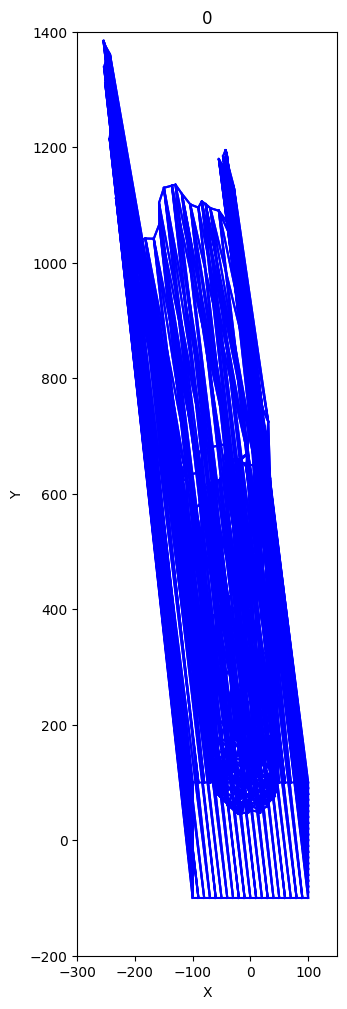

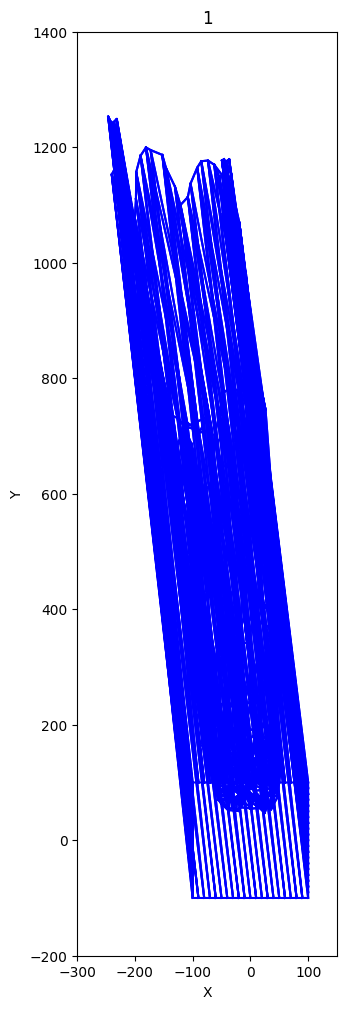

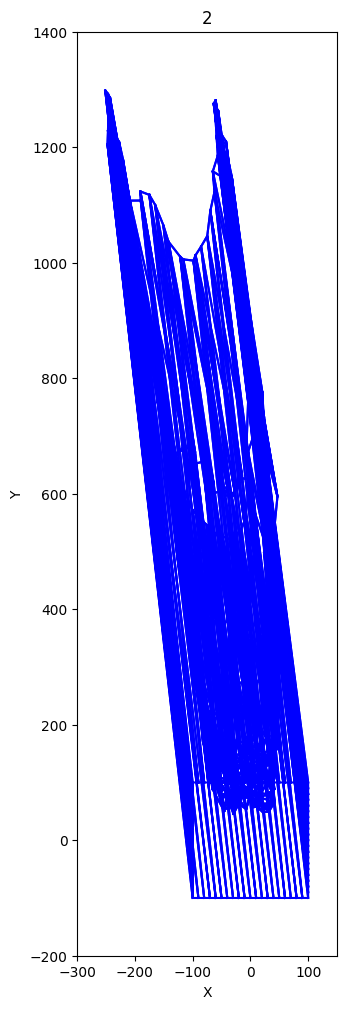

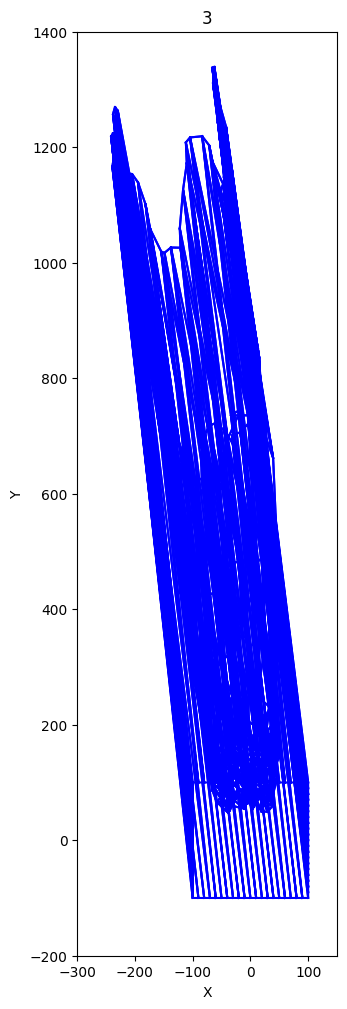

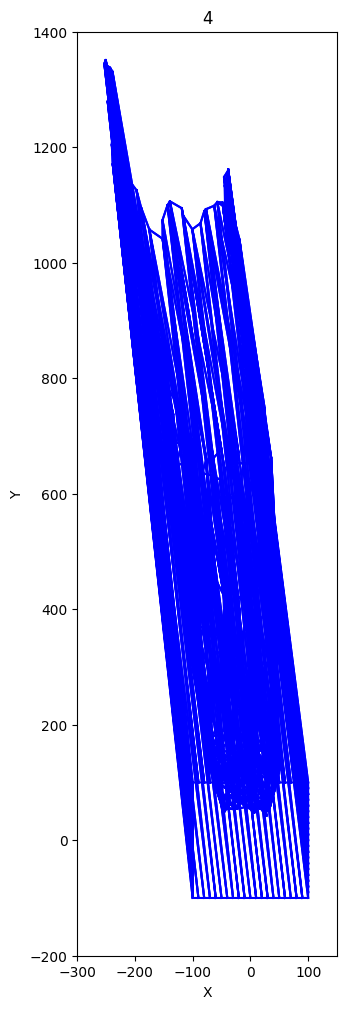

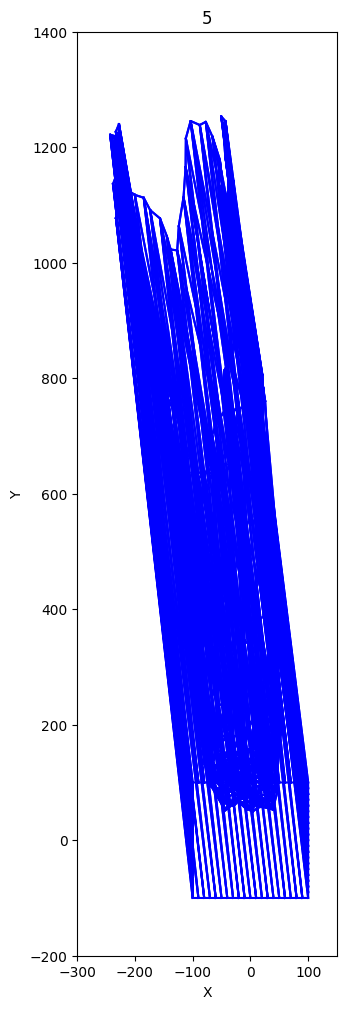

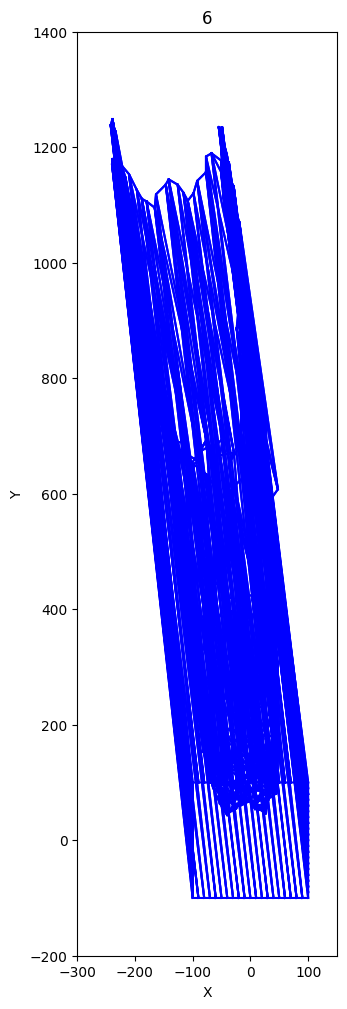

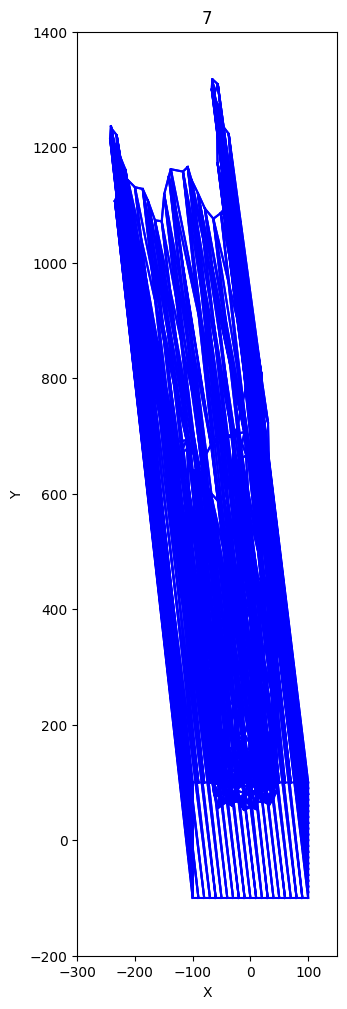

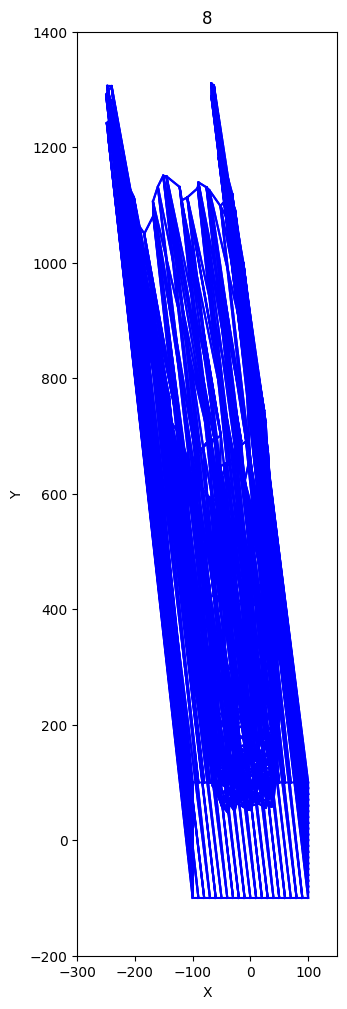

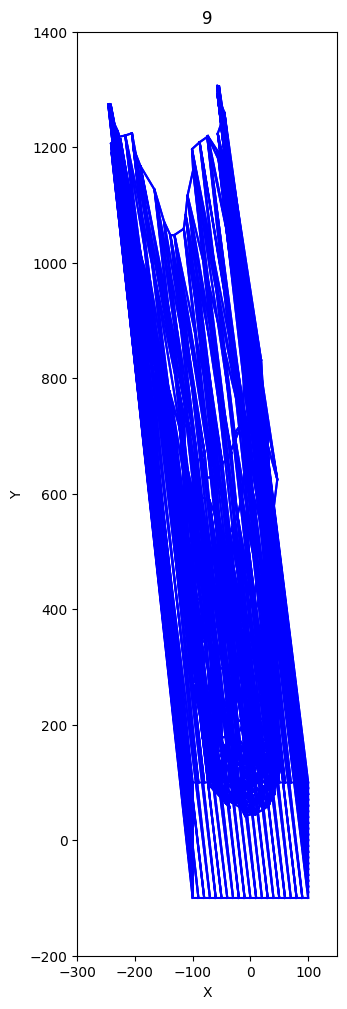

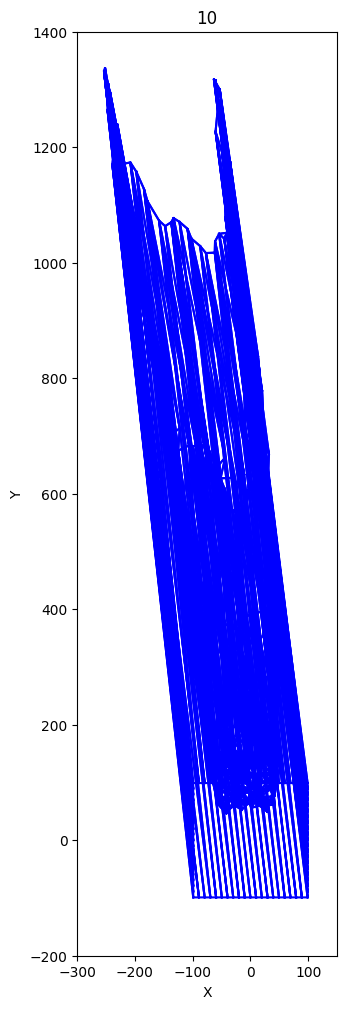

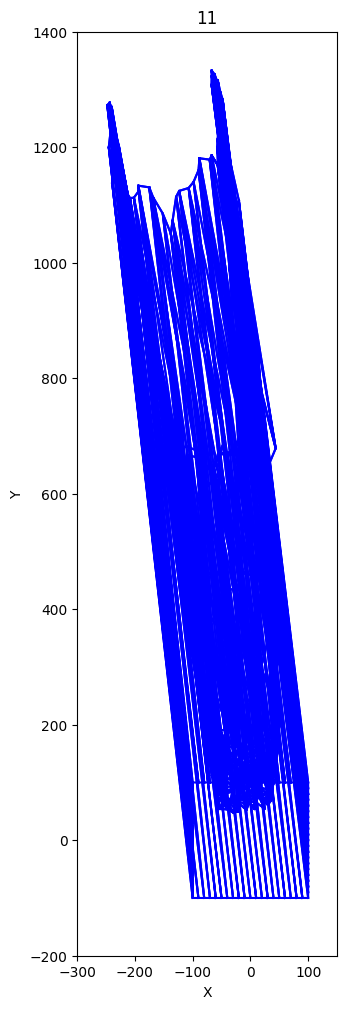

In [34]:
for i in range(num_train_mesh):
    plot_mesh(train_mesh_data_list[i], f"{i}")

In [ ]:
# # 100epochで最適化されたメッシュを10個生成する
# test_mesh_data_lists = [copy.deepcopy(test_mesh_data_list) for _ in range(10)]

# for trial in range(num_trial):
#     for epoch in tqdm(range(num_test_epoch)):
#         test_mesh_data_lists = test(device, trial, test_mesh_data_lists)


In [ ]:
# best_mesh_data_list = []
# num_test_mesh = len(test_vtk_files)
    
# for i in tqdm(range(num_test_mesh)):
#     q_hat_list = []
#     for j in range(10):
#         mesh = test_mesh_data_lists[j][i]

#         # q_hat を求めるコード
#         q_hat = calculate_q_hat(mesh)
        
#         q_hat_list.append(q_hat)
#         best = q_hat_list.index(min(q_hat_list))
#         best_mesh_data_list.append(test_mesh_data_lists[best + 1][i])
    


#     # best_mesh_data_list[i] のデータをvtkファイルで出力する
#     vtk_output(best_mesh_data_list[i], f"optimized_{i}")

## 更新したメッシュを表示してみる

In [ ]:
# for i in range(num_test_mesh):
#     plot_mesh(best_mesh_data_list[i], f"optimized_{i}")

# 元のメッシュから座標が変わっているか確認する

In [ ]:
# for i in range(num_test_mesh):
#     print(test_mesh_data_list[i].coordinates.size())
#     print(best_mesh_data_list[i].coordinates.size())


In [ ]:
# for i in range(num_test_mesh):
#     if torch.equal(test_mesh_data_list[i].coordinates, best_mesh_data_list[i].coordinates):
#         print("Not updated!!")
    
#     else:
#          print("Updated")